### Михаил Ховричев

Разработана программа по тематической классификации текста *с использованием машинного обучения* с помощью **word2vec**.
В качестве размеченных данных были взяты материалы с сайта http://www.world-art.ru/. Скрипт для скрэпинга материалов -- в файле parser.py
Данные на русском языке (в нужном объёме) довольно сложно получить. Так, например, данный сайт оказался одним из немногих, которые вообще позволили скрэпить данные, но процесс крайне осложнён -- каждые несколько запросов сайт банит по IP на полчаса. Рекомендую это учесть и сразу давать данные для обучения.

В разработанной программе частично использованы свободные материалы с семинара Яндекса.
https://events.yandex.ru/lib/talks/4137/

In [415]:
import csv
import pymorphy2
import nltk
from nltk import word_tokenize
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from itertools import islice
from sklearn import linear_model
import gensim
from sklearn.neighbors import KNeighborsClassifier
import re

%matplotlib inline

In [393]:
"""функция для графического отображения матрицы возмущений"""
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap) # интерполяция методом NN, как в диаграмме Вороного
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(genres))
    target_names = genres
    plt.xticks(tick_marks, target_names, rotation=90)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True genre')
    plt.xlabel('Predicted genre')

In [395]:
"""функция для расчёта точности и построения текстовой матрицы возмущения"""
def evaluate_prediction(predictions, target, title='Confusion matrix'):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [443]:
"""
Функция расчёта усреднённого вектора документа.
В word2vec каждому слову приписывается его векторное представление.
Нам же нужно получить векторное представление документа.
"""
def word_averaging(wv, words):
    all_words = set()
    mean = []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        return np.zeros(wv.layer_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32) # нормировка
    return mean

In [445]:
"""
Расчёт усреднённого вектора для каждого документа в датасете.
"""
def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list])

In [444]:
"""
Функция токенизации.
NLTK не распознаёт кавычки-ёлочки, поэтому отдельно отчищаем их от токенов.
"""
def my_tokenizer(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if '«' or '»' in word:
                word = re.sub('[\«\»]', '', word)
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [390]:
# Как и во всех моих ДЗ, будем приводить документы к стандартному представлению с помощью связки NLTK+pymorphy2
from nltk.corpus import stopwords
sw = stopwords.words('russian')
badPOS = {'NPRO','PREP', 'CONJ', 'PRCL', 'INTJ','PNCT', 'NUMB', 'ROMN', 'UNKN', 'Apro'}
morph = pymorphy2.MorphAnalyzer()

In [391]:
pd.set_option('display.max_colwidth', 80) # для отображения

Ознакомимся с данными. Это сюжеты аниме с отмеченным жанром. Для работы с данными и машинного обучения используем классическую связку (pandas, numpy, matplotlib, scikit-learn).

In [374]:
path = 'data/anime_data.csv'
df = pd.read_table(path)
df = df.dropna()
df.head()

,plot,genre
0,"Год 1988. Огромный взрыв наподобие тех, что без малого полвека назад сотрясл...",фантастика
1,Никогда еще в школьном аниме не собиралась такая веселая и сплоченная девичь...,повседневность
2,Через предательство и кровь к власти пришел новый король. Его демоны-подручн...,повседневность
3,"Девочка Мимико – сирота. У нее нет ни папы, ни мамы, есть только старенькая ...",романтика
4,Насколько связана реальность и виртуальный мир? Четырнадцатилетняя школьница...,фантастика


In [429]:
df.shape

(417, 2)

In [433]:
print("Количество слов в корпусе:", df['plot'].apply(lambda x: len(x.split(' '))).sum())

Количество слов в корпусе: 62845


Как видим, корпус довольно небольшой.

In [375]:
genres = df['genre'].unique()
print('Количество жанров:', len(genres))
print(genres)

Количество жанров: 6
['фантастика' 'повседневность' 'романтика' 'драма' 'приключения' 'комедия']


0.23741007194244604

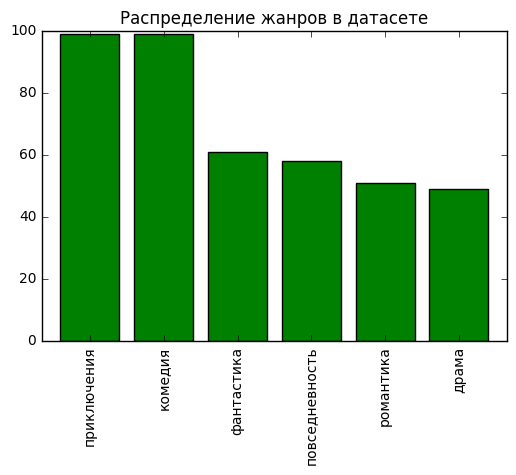

In [392]:
df['plot'].apply(lambda x: len(x.split(' '))).sum()
df.genre.value_counts().plot(kind="bar", width=0.8, rot=90, title='Распределение жанров в датасете', color='g')
# удельная доля жанра "приключения" (baseline)
df.genre.value_counts()['приключения']/df.genre.value_counts().sum()

Разделим данные на обучающую и контрольную выборки в соотношении 90%-10%.

In [377]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=330)
len(test_data)

42

0.19047619047619047

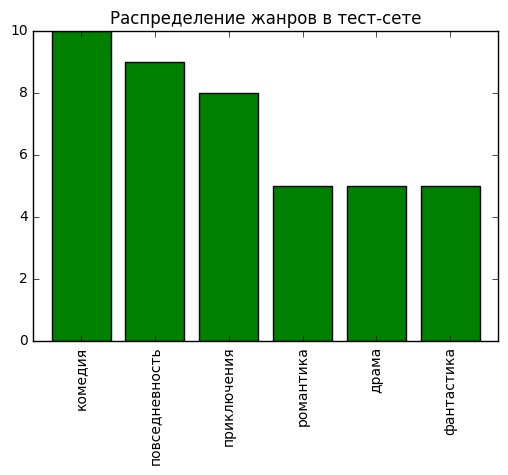

In [378]:
test_data.genre.value_counts().plot(kind="bar",width=0.8,rot=90, title='Распределение жанров в тест-сете', color='g')
test_data.genre.value_counts()['приключения']/test_data.genre.value_counts().sum()

Как видим, доля жанра "приключения" в тестовой выборке составляет порядка 19%.

Произведём токенизацию с помощью функции my_tokenizer.

In [385]:
test_tokenized = test_data.apply(lambda x: my_tokenizer(x['plot']), axis=1).values
train_tokenized = train_data.apply(lambda x: my_tokenizer(x['plot']), axis=1).values

Произведём лемматизацию. Аналогичная производилась и в предыдущих ДЗ.

In [386]:
transform = lambda x: morph.parse(x)[0]
condition = lambda x: not [item for item in badPOS if item in str(transform(x).tag)] and transform(x).word not in sw

test_lemmatized = [[transform(token).normal_form for token in doc if condition(token)] for doc in test_tokenized]
train_lemmatized = [[transform(token).normal_form for token in doc if condition(token)] for doc in train_tokenized]

Теперь будем обучать модель. Для этого объединим нормализованные выборки.
Для имплементации word2vec используем gensim.

In [527]:
sentences = test_lemmatized+train_lemmatized
model = Word2Vec(sentences, size=150)
model.init_sims(replace=True)

Посмотрим на модель.

In [528]:
model.most_similar("любовь")

[('человек', 0.9998202919960022),
 ('жизнь', 0.9998162388801575),
 ('девушка', 0.9998117089271545),
 ('сила', 0.9998102188110352),
 ('парень', 0.9998069405555725),
 ('мир', 0.9998056292533875),
 ('друг', 0.9998050332069397),
 ('время', 0.9997981786727905),
 ('стать', 0.9997965693473816),
 ('дело', 0.9997923374176025)]

Приведём каждый документ в выборках к векторному представлению с помощью функций word_averaging, word_averaging_list.

In [529]:
test_WA = word_averaging_list(model, test_tokenized)
train_WA = word_averaging_list(model, train_tokenized)

Воспользуемся логистической регрессией для предсказания. Логистическая регрессия выбрана, как показывающая немного лучшие результаты в сравнении с тем же методом ближайшего соседа. 

In [536]:
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e6)
logreg = logreg.fit(train_WA, train_data['genre'])
predicted = logreg.predict(test_WA)

Посмотрим, что у нас получилось. В матрице возмущений в текстовом виде подсчёт идёт по количествам, в графическом -- по удельной доле. Концентрироваться числам (или синим квадратикам) нужно на диагонали. Большее число (интенсивность цвета) на диагонали -- хорошо, вне диагонали -- плохо.

accuracy 0.214285714286
confusion matrix
 [[0 1 1 1 0 2]
 [2 4 1 1 1 1]
 [0 4 1 0 3 1]
 [1 0 0 2 2 3]
 [0 2 1 0 2 0]
 [0 1 2 2 0 0]]
(row=expected, col=predicted)


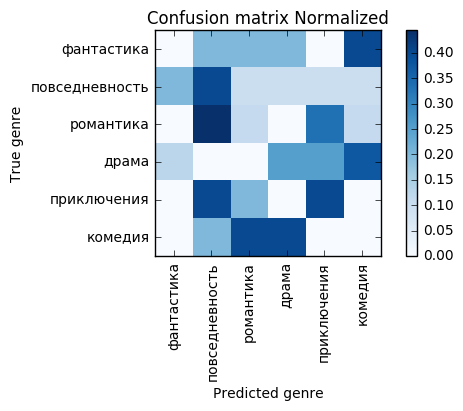

In [537]:
evaluate_prediction(predicted, test_data.genre)

Не очень здорово. 21% -- это лучше, чем 19%, но незначительно. (Однако это не программа плохая, так что невысокая точность, как мне кажется, не повод для снижения оценки). Что является причиной? 

1. Размер корпуса. Он действительно небольшой, а достать данные оказалось не такой простой задачей (для sentiment analysis это сделать намного проще, но анализ тональности, хоть и подзадача данной задачи, -- это другой вариант ДЗ). 

2. В изначальных данных было больше классов ("фэнтези", "сёдзе-ай" и др.), но они имели от 1 до 3 представителей, что создавало сильный дисбаланс в данных (многие  жанры даже не попадали в тестовую выборку), поэтому подобные сюжеты были присоединены к имеющимся по семантике ("фэнтези" -> "фантастика", "сёдзе-ай" -> "романтика" и т.д). Возможно, этого делать не стоило, однако несбалансированные данные -- это хуже.

3. Аниме по сути своей достаточно эмоциональный вид анимации, в нём часто обыгрываются отношения между людьми, поэтому лексически описание "романтических" сюжетов мало отличается от "повседневных". Это видим и в матрице -- классификатор их путает.

Теперь отвлечёмся от грустных мыслей о точности модели и исследуем результат.

"Фантастика" часто определяется как "комедия" (а наоборот классификатор не путает).
"Повседневность" определяется относительно хорошо, но "повседневные" жанры предсказываются как что угодно.
"Романтика" часто определяется как "повседневность".
"Драма" часто путается с "комедией". Причём в обе стороны.
"Приключения" определяются лучше, чем всё остальное. Но, как ни странно, совершенно не путаются с "фантастикой".
"Комедия" часто определяется, как "романтика" и "драма". Первое ещё как-то объяснимо, второе -- неожиданно.

В целом, программа составлена верно, учтены все аспекты предобработки текста, удалены все стоп-слова, произведена лемматизация, результаты . Использовано машинное обучение. Осталось взять побольше данных, и результат будет точным.